In [2]:
import sys
import os


sys.path.append(os.path.abspath("/Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation"))
from imports import *

from datasets import load_dataset
import pandas as pd

/Users/monika/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [233]:
file_path = 'Datasets/udataset.xlsx'
#file_path = "new.xlsx"

In [285]:
df = pd.read_excel(file_path)
df.head()

,Substance,Substance_lower,CAS_number,SMILES,Additional info,Irritation,Source
0,Heptanal,heptanal,111-71-7,CCCCCCC=O,-,I,Lukáš - 2006 Howard Maibach paper.pdf
1,Lilestralis/lilial,lilestralis/lilial,80-54-6,CC(CC1=CC=C(C=C1)C(C)(C)C)C=O,-,I,NaN
2,1-Bromopentane,1-bromopentane,110-53-2,CCCCCBr,-,I,NaN
3,dl-Citronellol,dl-citronellol,106-22-9,CC(CCC=C(C)C)CCO,-,I,NaN
4,d-Limonene,d-limonene,5989-27-5,CC1=CCC(CC1)C(=C)C,-,I,NaN


## Data loading

In [286]:
#https://huggingface.co/datasets/maomlab/AttentiveSkin

dataset_train = load_dataset("maomlab/AttentiveSkin", "Irrit_Neg", split="train")
dataset_test = load_dataset("maomlab/AttentiveSkin", "Irrit_Neg", split="test")

# Convert to Pandas DataFrame
df_train = pd.DataFrame(dataset_train)
df_test = pd.DataFrame(dataset_test)

rabits = pd.concat([df_train, df_test], ignore_index=True)
#df = df_test

# Display the first few rows
print(rabits.head())

                                                Name  \
0                    JP_CHRIP:\np-Nitrochlorobenzene   
1                          US_HSDB:\n4-Acetylanisole   
2                    NZ_CCID:\n4-Nitrobenzyl bromide   
3  EU_REACH:\nbutyl N-[(butylsulfanyl)methanethio...   
4  EU_REACH:\n(1S,3R,5R,6S,8R,10R,11S,13R,15R,16S...   

                                             Synonym        CAS RN  Y  \
0  JP_CHRIP:\np-Chloronitrobenzene\n1-Chloro-4-ni...      100-00-5  0   
1                                               None      100-06-1  1   
2                                               None      100-11-8  1   
3                                               None  1001320-38-2  0   
4                                               None    10016-20-3  0   

                                       Detailed Page  \
0  JP_CHRIP: https://www.nite.go.jp/chem/ghs/21-m...   
1  US_HSDB: https://pubchem.ncbi.nlm.nih.gov/sour...   
2  NZ_CCID: https://www.epa.govt.nz/database-sear...   


## Descriptor calculation

In [287]:
rabits = rabits[rabits["OECD TG 404"] == "Provided"]
#df = pd.concat([df_old, rabits], ignore_index=True)

In [288]:
rabits.shape

(1338, 14)

In [120]:
def calculate_descriptors(df):
    # List to hold descriptor data for each row
    descriptor_data = []
    
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            # Append a dictionary of None values for all descriptors if SMILES is invalid
            descriptor_data.append({desc[0]: None for desc in Descriptors.descList})
            continue
        
        descriptors = {}
        for descriptor, function in Descriptors.descList:
            try:
                descriptors[descriptor] = function(mol)
            except Exception:
                descriptors[descriptor] = None
        
        descriptor_data.append(descriptors)
    
    # Create a DataFrame for descriptor values with the same index as the original DataFrame
    descriptors_df = pd.DataFrame(descriptor_data, index=df.index)
    
    # Concatenate original DataFrame with descriptor DataFrame
    df = pd.concat([df, descriptors_df], axis=1)
    
    return df

In [289]:
df = calculate_descriptors(df)

[08:08:46] WARNING: not removing hydrogen atom without neighbors
[08:08:46] WARNING: not removing hydrogen atom without neighbors
[08:08:46] WARNING: not removing hydrogen atom without neighbors


In [290]:
rabits = calculate_descriptors(rabits)
#f_o = calculate_descriptors(df_o)

In [319]:
rabits.rename(columns={"Y":"Irritation"}, inplace=True)

In [320]:
df['Irritation'] = df['Irritation'].replace({'I': 1, 'NI': 0})
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Irritation
0,0.624798,0.624798,0.091173,0.691680,0.403803,0.148374,0.082294,0.071850,0.082275,0.102041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,1
1,0.673883,0.673883,0.014125,0.654458,0.725612,0.221138,0.174802,0.160585,0.174768,0.188776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
2,0.214301,0.214301,0.141926,0.716199,0.440935,0.146341,0.120127,0.113942,0.119150,0.076531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,1
3,0.551992,0.551992,0.040037,0.666977,0.634828,0.206948,0.125487,0.109879,0.125464,0.147959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
4,0.254228,0.254228,0.093278,0.692697,0.501957,0.419512,0.104927,0.092994,0.104894,0.122449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1


In [293]:
common_smiles = set(df["SMILES"]).intersection(rabits["SMILES"])

In [294]:
len(common_smiles)

15

In [295]:
# Merge on SMILES with an inner join
merged = pd.merge(rabits[['SMILES', 'Irritation']], df[['SMILES', 'Irritation']],
                  on='SMILES', suffixes=('_rabits', '_df'))

# Find rows where Irritation labels differ
conflicts = merged[merged['Irritation_rabits'] != merged['Irritation_df']]

# Count them
conflicting_count = len(conflicts)

print("Number of conflicting SMILES:", conflicting_count)

print(conflicts.head())


Number of conflicting SMILES: 5
                    SMILES  Irritation_rabits  Irritation_df
0             CCCCCC(=O)OC                  0              1
4        CCCCCCCCCCCC(=O)O                  0              1
9   CCCCCCCCCCCCCCCC(=O)OC                  1              0
13            CCCCOC(=O)CC                  0              1
15                CCCSSCCC                  1              0


In [272]:
r_clean = rabits[~rabits["SMILES"].isin(common_smiles)]

## Columns cleaning

In [296]:
columns_to_drop = ["Substance", "Substance_lower", "CAS_number", "SMILES", "Additional info", "Source"]

# Drop the columns using the drop() method with axis=1 (columns)
df = df.drop(columns_to_drop, axis=1)
df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,3,0
1,1,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,1,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,1,0
3,1,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,0,0,0,0,0,0,0
4,1,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,0,0,0,0,0,0,0


In [297]:
columns_to_drop = ["Name", "Synonym", "CAS RN", "Detailed Page", "Evidence", "OECD TG 404", "Data Source","Frequency","SMILES", "SMILES URL", "SMILES Source",   "Canonical SMILES", "Split"]


rabits = r_clean.drop(columns_to_drop, axis=1)
rabits.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,10.074698,10.074698,0.059630,-0.461975,0.463602,9.300000,157.556,153.524,156.993056,...,0,0,0,0,0,0,0,0,0,0
3,0,11.126813,11.126813,0.432918,-0.432918,0.578640,9.733333,249.401,230.249,249.085721,...,1,0,0,0,0,0,0,0,2,0
4,0,11.216799,11.216799,0.998871,-2.148030,0.117489,55.363636,972.846,912.366,972.316941,...,0,0,0,0,0,0,0,0,0,0
7,0,14.593817,14.593817,0.033954,-0.843042,0.446513,25.925926,376.531,342.259,376.257772,...,0,0,0,0,0,0,0,0,1,0
8,0,8.223565,8.223565,0.296296,0.296296,0.494725,8.500000,108.100,104.068,108.032363,...,0,0,0,0,0,0,0,0,0,0


In [247]:
rabits.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,10.074698,10.074698,0.059630,-0.461975,0.463602,9.300000,157.556,153.524,156.993056,...,0,0,0,0,0,0,0,0,0,0
3,0,11.126813,11.126813,0.432918,-0.432918,0.578640,9.733333,249.401,230.249,249.085721,...,1,0,0,0,0,0,0,0,2,0
4,0,11.216799,11.216799,0.998871,-2.148030,0.117489,55.363636,972.846,912.366,972.316941,...,0,0,0,0,0,0,0,0,0,0
7,0,14.593817,14.593817,0.033954,-0.843042,0.446513,25.925926,376.531,342.259,376.257772,...,0,0,0,0,0,0,0,0,1,0
8,0,8.223565,8.223565,0.296296,0.296296,0.494725,8.500000,108.100,104.068,108.032363,...,0,0,0,0,0,0,0,0,0,0


In [298]:
df = pd.concat([df, rabits], ignore_index=True)

In [299]:
df.head()

,Irritation,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,1,9.768009,9.768009,0.750000,0.750000,0.395123,9.125000,114.188,100.076,114.104465,...,0,0,0,0,0,0,0,0,3,0
1,1,10.535393,10.535393,0.116191,0.116191,0.689906,13.600000,204.313,184.153,204.151415,...,0,0,0,0,0,0,0,0,0,0
2,1,3.350347,3.350347,1.167500,1.167500,0.429137,9.000000,151.047,139.959,150.004412,...,0,0,0,0,0,0,0,0,1,0
3,1,8.629773,8.629773,0.329353,0.329353,0.606746,12.727273,156.269,136.109,156.151415,...,0,0,0,0,0,0,0,0,0,0
4,1,3.974575,3.974575,0.767315,0.767315,0.485034,25.800000,136.238,120.110,136.125201,...,0,0,0,0,0,0,0,0,0,0


In [300]:
columns_to_drop = ["BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW"]

df = df.drop(columns_to_drop, axis=1)

In [302]:
df.shape

(1769, 203)

## Nan values

In [303]:
# Count NaN values per column
nan_counts = df.isna().sum()

# Filter columns with NaN values and sort by count
nan_columns_sorted = nan_counts[nan_counts > 0].sort_values(ascending=False)

print(nan_columns_sorted)

MaxPartialCharge       4
MinPartialCharge       4
MaxAbsPartialCharge    4
MinAbsPartialCharge    4
dtype: int64


In [304]:
# Count the number of rows before dropping NaN values
num_rows_before = df.shape[0]

# Drop rows with NaN values
df.dropna(inplace=True)

# Count the number of rows after dropping NaN values
num_rows_after = df.shape[0]

# Calculate the number of rows dropped
num_rows_dropped = num_rows_before - num_rows_after

print("Number of rows dropped:", num_rows_dropped)

Number of rows dropped: 4


In [305]:
df = df.reset_index(drop=True)

# Basic statistics

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Columns: 203 entries, Irritation to fr_urea
dtypes: float64(98), int64(105)
memory usage: 2.7 MB


In [63]:
df.nunique()

Irritation              2
MaxAbsEStateIndex    1631
MaxEStateIndex       1631
MinAbsEStateIndex    1614
MinEStateIndex       1647
                     ... 
fr_thiazole             3
fr_thiocyan             2
fr_thiophene            3
fr_unbrch_alkane       28
fr_urea                 3
Length: 203, dtype: int64

In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Irritation,1764.0,0.199546,0.399773,0.000000,0.000000,0.000000,0.000000,1.000000
MaxAbsEStateIndex,1764.0,10.092368,2.984943,0.000000,8.953338,10.853691,12.141633,15.633873
MaxEStateIndex,1764.0,10.091731,2.984863,0.000000,8.953338,10.846122,12.141633,15.633873
MinAbsEStateIndex,1764.0,0.330023,0.600863,0.000000,0.064252,0.181173,0.375572,8.226135
MinEStateIndex,1764.0,-1.007670,1.707150,-11.027778,-1.190819,-0.517509,-0.031101,6.000000
...,...,...,...,...,...,...,...,...
fr_thiazole,1764.0,0.006236,0.085644,0.000000,0.000000,0.000000,0.000000,2.000000
fr_thiocyan,1764.0,0.000567,0.023810,0.000000,0.000000,0.000000,0.000000,1.000000
fr_thiophene,1764.0,0.009070,0.100636,0.000000,0.000000,0.000000,0.000000,2.000000
fr_unbrch_alkane,1764.0,1.119615,3.475199,0.000000,0.000000,0.000000,0.000000,39.000000


## Drop constant columns

In [307]:
constant_columns = df.columns[df.nunique() <= 1]  # Columns with 1 or fewer unique values
print(f"Constant columns removed: {list(constant_columns)}")
df = df.drop(columns=constant_columns)

Constant columns removed: ['SMR_VSA8', 'SlogP_VSA9', 'fr_benzodiazepine', 'fr_dihydropyridine', 'fr_isothiocyan', 'fr_nitroso', 'fr_prisulfonamd']


## Scaling

In [308]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Separate features and label
features = df.drop(columns=["Irritation"])
label = df["Irritation"]

# Initialize scaler and fit only on features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Convert back to DataFrame with original column names
scaled_df = pd.DataFrame(scaled_features, columns=features.columns, index=df.index)

# Add the label column back
df_scaled = pd.concat([scaled_df, label], axis=1)

# Resulting DataFrame
df = df_scaled
df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,Irritation
0,0.624798,0.624798,0.091173,0.691680,0.403803,0.148374,0.082294,0.071850,0.082275,0.102041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,1
1,0.673883,0.673883,0.014125,0.654458,0.725612,0.221138,0.174802,0.160585,0.174768,0.188776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
2,0.214301,0.214301,0.141926,0.716199,0.440935,0.146341,0.120127,0.113942,0.119150,0.076531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025641,0.0,1
3,0.551992,0.551992,0.040037,0.666977,0.634828,0.206948,0.125487,0.109879,0.125464,0.147959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
4,0.254228,0.254228,0.093278,0.692697,0.501957,0.419512,0.104927,0.092994,0.104894,0.122449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1


In [318]:
list(df.columns)

['MaxAbsEStateIndex',
 'MaxEStateIndex',
 'MinAbsEStateIndex',
 'MinEStateIndex',
 'qed',
 'SPS',
 'MolWt',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'NumRadicalElectrons',
 'MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'AvgIpc',
 'BalabanJ',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'PEOE_VSA1',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'PEOE_VSA9',
 'SMR_VSA1',
 'SMR_VSA10',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA5',
 'SMR_VSA6',
 'SMR_VSA7',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA12',
 'SlogP_VSA2',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'S

In [310]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

## Class distribution

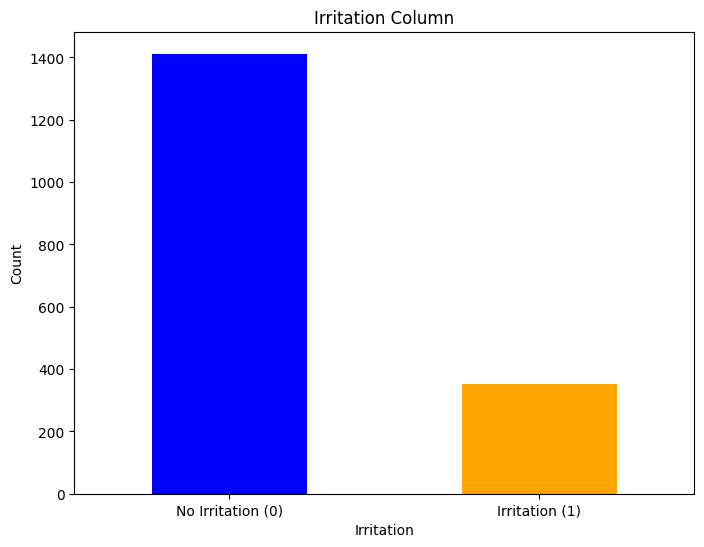

In [311]:
# Plotting class imbalance
plt.figure(figsize=(8, 6))
df['Irritation'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Irritation Column')
plt.xlabel('Irritation')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Irritation (0)', 'Irritation (1)'], rotation=0)
plt.show()

In [312]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.spatial.distance import cdist


X = df.drop(columns="Irritation")
y = df["Irritation"]

majority_class = 0

# 1. Vyber väčšinovú triedu a resetuj indexy
X_majority = X[y == majority_class].reset_index(drop=True)

# 2. Škálovanie dát
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_majority)

# 3. KMeans clustering (napr. 50 klastrov)
n_clusters = 350  
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# 4. Vyber 1 najbližšiu vzorku ku každému centroidu
centroids = kmeans.cluster_centers_
distances = cdist(X_scaled, centroids)
closest_indices = np.argmin(distances, axis=0)

# 5. Zostav nový dataset (vybrané vzorky z väčšinovej triedy)
X_majority_selected = X_majority.iloc[closest_indices]
y_majority_selected = pd.Series([majority_class] * len(closest_indices), index=X_majority_selected.index)

# 6. Pridaj všetky vzorky minoritnej triedy
X_minority = X[y != majority_class]
y_minority = y[y != majority_class]

# 7. Spoj dokopy
X_final = pd.concat([X_majority_selected, X_minority], axis=0)
y_final = pd.concat([y_majority_selected, y_minority], axis=0)

# 8. Zamiešaj výsledný dataset
X_final, y_final = shuffle(X_final, y_final)


In [313]:
df_final = X_final.copy()
df_final["Irritation"] = y_final.values


In [314]:
df_final.shape

(703, 196)

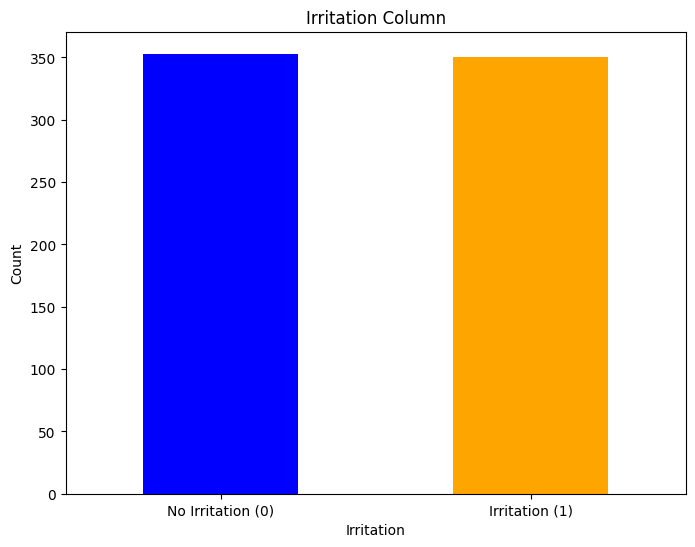

In [315]:
# Plotting class imbalance
plt.figure(figsize=(8, 6))
df_final['Irritation'].value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.title('Irritation Column')
plt.xlabel('Irritation')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Irritation (0)', 'Irritation (1)'], rotation=0)
plt.show()

# Outliers

In [324]:
def detect_outliers(df):
    if isinstance(df, np.ndarray):
        df = pd.DataFrame(df)
    # Calculate the first quartile (Q1) and third quartile (Q3)
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outlier_mask = (df < lower_bound) | (df > upper_bound)
    
    # Replace outliers with median
    median_values = df.median(axis=1)
    df = df.where(~outlier_mask, median_values, axis=0)


    outliers = df[outlier_mask.any(axis=1)]
    num_outliers = outliers.shape[0]
    print(f"Number of outliers detected and fixed: {num_outliers}")

    return df

In [325]:
df = detect_outliers(df)

Number of outliers detected and fixed: 1598


# Data download

In [86]:
import os

# Define the file name (you can customize it)
file_name = "test.xlsx"

# Export the DataFrame to Excel
df.to_excel(file_name, index=False)  # index=False excludes the index column

# Optionally, you can confirm the file was saved in the current directory
print(f"File saved to: {os.path.abspath(file_name)}")


File saved to: /Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation/test.xlsx


In [317]:
import os

# Define the file name (you can customize it)
file_name = "rabbit_balanced_2.xlsx"

# Export the DataFrame to Excel
df_final.to_excel(file_name, index=False)  # index=False excludes the index column

# Optionally, you can confirm the file was saved in the current directory
print(f"File saved to: {os.path.abspath(file_name)}")


File saved to: /Users/monika/Desktop/DP/DP_QSAR_Skin_Irritation/rabbit_balanced_2.xlsx
